[View in Colaboratory](https://colab.research.google.com/github/mforbes/wsu_physics_450/blob/master/Notebooks/Discretization.ipynb)

# Contents

>[Discretization and Fourier Transforms](#scrollTo=Uym8J8NJfNRA)

>[Schrödinger Equation](#scrollTo=2hx6tydFGRvk)

>>[Finite set of Energy Eigenstates](#scrollTo=fvR6NXsaJ_vF)

>>[General Finite Basis](#scrollTo=JXCBzm5ZKyMH)

>[Finite Differences](#scrollTo=d3yUHA5jNTtL)

>>[Boundary Conditions](#scrollTo=I1KsX2CMNYfb)

>>[Example: Harmonic Oscillator](#scrollTo=Hljc6P6gWR0K)

>>[Basis States (Incomplete)](#scrollTo=KRQNAA6sU5-9)

>[Fourier Methods (Spectral Methods)](#scrollTo=e9S9CD9tNhyS)

>>>[Numerical Normalization](#scrollTo=GV1UZ4Y4hBWv)

>>>[Alternative Normalization](#scrollTo=R--87Ng-qdft)

>>>[Code](#scrollTo=DOGtx4ZoufOy)



# Discretization and Fourier Transforms

*This cell also defines some math macros:*

$$
  \newcommand{\abs}[1]{\lvert#1\rvert}
  \newcommand{\ket}[1]{\lvert#1\rangle}
  \newcommand{\bra}[1]{\langle#1\rvert}
  \newcommand{\braket}[1]{\langle#1\rangle}  
  \newcommand{\Ket}[1]{\left\lvert#1\right\rangle}
  \newcommand{\Bra}[1]{\left\langle#1\right\rvert}
  \newcommand{\Braket}[1]{\left\langle#1\right\rangle}
  \newcommand{\op}[1]{\hat{\boldsymbol{#1}}}
  \newcommand{\mat}[1]{\boldsymbol{#1}}
  \newcommand{\I}{\mathrm{i}}
  \newcommand{\d}{\mathrm{d}}
  \newcommand{\floor}[1]{\lfloor\!#1\!\rfloor}
  \newcommand{\Floor}[1]{\left\lfloor\!#1\!\right\rfloor}
  \DeclareMathOperator{\sinc}{sinc}
$$
* `\bra{x}`=$\bra{x}$
* `\ket{x}`=$\ket{x}$
* `\braket{x|k}`=$\braket{x|k}$
* `\op{p}`=$\op{p}$
* `\Floor{\frac{N}{2}}`=$\Floor{\frac{N}{2}}$
* etc.

Some notations:

* Abstract operators are bold and notated with a hat: $\op{X}$, $\op{P}$, $\op{H}$, etc.
* Abstract state vectors are denoted with kets: $\ket{\psi}$.
* Matrices are denoted without a hat (but still bold): $\mat{H}$.  These must be expressed in some sort of basis which will be made explicit by context.
* The explicit elements of a matrix will be expressed using square brackets: $[\mat{H}]_{ij}$.  Thus:

  $$
    \braket{m|\op{H}|n} = [\mat{H}]_{mn} = H_{mn}.
  $$
  
  The bracket notation is useful when expressing the indices of a more complex expression, for example $[\mat{A}\cdot\mat{B}]_{ij} = \sum_{a}A_{ia}B_{aj} \equiv A_{ia}B_{aj}$.  Sometimes, when obvious, the summation of repeated indices may be omitted as shown.  (This is related to the [Einstein summation convention](https://en.wikipedia.org/wiki/Einstein_notation), though we shall not distinguish between covariant (upper) and contravariant (lower) indices.)


# Schrödinger Equation

To render the Schödinger equation finite, we must discretize our solutions so that the Hilbert space becomes finite dimensional.  There is no unique way to do this and you must choose a method that suits your application.

The general strategy is to choose some finite set of basis states $\ket{n}$ and use these to express the Hamiltonian.  Some possible choices include:

## Finite set of Energy Eigenstates

If you Hamiltonian is time-independent and has a discrete spectrum (the energy eigenvalues $E_n$ are enumerable by an integer index $n$ for example), then you might choose as a basis the lowest $N$ eigenstates of the Hamiltonian $\op{H}\ket{n} = E_n\ket{n}$.  The time dependent problem can be solved by expressing the initial state in terms of these through a finite set of coefficients $\psi_n = \braket{n|\psi}$:

$$
    \ket{\psi(t)} = \sum_{n=0}^{N-1} e^{E_n (t-t_0)/\I\hbar}\ket{n}\overbrace{\braket{n|\psi(t_0)}}^{\psi_n}.
$$
  
Here the finite Hilbert space $H_N$ is spanned by the basis of $N$ energy eigenstates $\{\left.\ket{n}\right|_{n=0}^{N-1}\}$ and has dimension $N$.  The  errors induced by this approximation can be assessed by seeing how well the original state can be expressed in $H_N$.  This can be computed using the following projection operator which projects the original state into the finite-dimensional Hilbert space $H_N$:
  
$$
    \op{P}_N = \sum_{n=0}^{N-1} \ket{n} \bra{n}, \qquad
    \ket{\psi_N} = \op{P}_N\ket{\psi}
$$
  
Errors in this approximation will be proportional to the difference between the projection $\ket{\psi_N}$ and the original state:
  
$$
    \braket{\psi|\psi_N}-\braket{\psi|\psi}.
$$
  
If the original state $\ket{\psi}$ is well represented by the basis, this will be a good approximation.  (If the initial state lies completely in $H_N$, then the method is essentially exact.)
  
This is the approach used in the notebook [Particle in a Box](Particle%20in%20a%2Box.ipynb) notebook.

This is generally an excellent strategy if feasible, but has some drawbacks that may make it infeasible:

* Large errors if the initial state does not lie in the finite Hilbert space $H_N$.
* Computing the overlap coefficients $\ket{n|\psi}$ might be expensive and/or error prone.
* Does not work if one cannot express the energy eigenstates $\ket{n}$.
* Does not work if the Hamiltonian is time-dependent.

## General Finite Basis

The previous method is related to a general approach.  Simply choose some finite set of $N$ basis states $\ket{n}$, regardless of whether or not they are the energy eigenstates, and then re-express the Schrödinger equation in this basis.  Again, one has the same projection operator:

$$
    \op{P}_N = \sum_{n=0}^{N-1} \ket{n} \bra{n}.
$$

The strategy is to express the Hamiltonian as a matrix in this basis, and then solve the problem as a general linear algrabra problem:

$$
  H_{mn} = \braket{m|\op{H}(t)|n}, \\
  \I\hbar\dot{\psi}_n(t) = \sum_{m=0}^{N-1}H_{mn}(t)\psi_{m}(t).
$$

Everything is now finite.  Solving the time-independent Schrödinger equation amounts to finding the eigenvalues and eigenvectors of the matrix $\mat{H}$ which has coefficients $[\mat{H}]_{mn}= H_{mn}$.  Solving the time-dependent eigenvalue problem amounts to solving the $N$ coupled first-order ordinary differential equations (ODEs).  Good numerical methods exist for both of these tasks.

This is a completely general approach and all remaining discussions will be specializations of this to specific basis sets, however, there are still some potential disadvantages.

* As before, if the initial state does not lie in the restricted subspace spanned by the basis, one will incur truncation errors.
* An additional complication is that, even if the original state lies in the subspace, the original Hamiltonian might have taken it out of the subspace.  This will also introduce errors.
* Computing the matrix elements $H_{mn} = \braket{m|\op{H}|n}$ might be expensive or error-prone.
* Performing the matrix multiplication $\mat{H}\cdot\vec{\psi}$ needed to solve the Schrödinger equation might be expensive.

# Finite Differences

A simple approach is to replace the derivative operators in the Hamiltonian with finite difference approximations.  We first define the approximation, then consider the basis that this represents.

To this end, we defined our wavefunctions as a set of $N$ numbers representing the value of the weavefunction at a pre-defined set of lattice points (abscissa) $x_n$.  For simplicity, we take the spacing between these points $\d{x} = x_{n+1} - x_{n}$ to be constant, though one can generalize.  The $N$ points will thus represent the wavefunction in a box of length $L = N\d{x}$ which we take to run from $-L/2$ to $L/2$ with the following lattice points:

$$
  x_n = \left(n\d{x} - \frac{L}{2}\right)_{n=0}^{N-1}, \qquad \d{x} = \frac{L}{N}.
$$

The wavefunctions will now be represented by a set of $N$ coefficients:

$$
  \psi_n(t) = \psi(x_n, t).
$$

We must now express the Laplacian which appears in the Hamiltonian as a matrix.  To do this, we use the following finite-difference approximation of the derivative:

$$
  \psi''_n \approx \frac{\psi_{n+1} - 2\psi_{n} + \psi_{n-1}}{\d{x}^2} + O\left(\d{x}^2\right)
$$

The error term can be estimated from the Taylor expansion:

$$
  \psi(x\pm h) = \psi(x) \pm h\psi'(x) + \frac{h^2}{2!}\psi''(x)
  \pm \frac{h^3}{3!}\psi''(x) + \frac{h^4}{4!}\psi'''(x) + \cdots.
$$

In this symmetric form, all terms cancel until the fourth order term.

The kinetic energy term of the Hamiltonian can thus be represented by a band-diagonal matrix:

$$
  \frac{\op{P}^2}{2m} \rightarrow \frac{-\hbar^2}{2m\;\d{x}^2}
  \begin{pmatrix}
    \smash{\ddots} & \smash{\ddots}\\
    \smash{\ddots} & -2 & 1\\
    & 1 &  -2  & 1\\
    && 1 &  -2  & 1\\
    &&& 1 &  -2  & \smash{\ddots}\\
    &&&& \smash{\ddots} &  \smash{\ddots}
  \end{pmatrix}, \qquad
  \op{V} \rightarrow
  \begin{pmatrix}
   \ddots\\
    & V(x_{n-1})\\
    && V(x_{n})\\
    &&& V(x_{n+1})\\
    &&&& \ddots
  \end{pmatrix}.
$$

The potential is represented by a diagonal matrix evaluated at the abscissa.

## Boundary Conditions

To complete this description, one needs to specify what to do at the start and end of the matrix for the kinetic energy.  These boundary conditions will define the nature of the solutions.  Two easy-to-implement conditions are:

* **Dirichlet**: With this formulation, it is most natural to implement [Dirichlet boundary conditions](https://en.wikipedia.org/wiki/Dirichlet_boundary_condition):

  $$
    \begin{gathered}
      \psi(x_{-1}) = \psi(x_{N}) = 0, \\
      L = (N+1)\d{x},
    \end{gathered}
    \qquad
    \begin{pmatrix}
      -2 & 1\\
      1 &-2 & \smash{\ddots}\\
      & \smash{\ddots} & \smash{\ddots} & \smash{\ddots}\\
      && \smash{\ddots} & -2 & 1\\
      &&& 1 & -2
    \end{pmatrix}
  $$
  
  This discretization is equivalent to assuming that $\psi(x_{-1}) = \psi(x_{N}) = 0$ and will enforce the boundary conditions that the solutions go smoothly to zero at the edges of the box.  This is equivalent to placing the entire system in an infinite box with length $L$.

* **Periodic**: One can also easily implement [periodic boundary conditions]()

  $$
    \begin{gathered}
      \psi(x_{-1}) = \psi(x_{N-1}), \\
      \psi(x_{N}) = \psi(x_{0}), \\
      L = N\d{x},
    \end{gathered} \qquad
    \begin{pmatrix}
      -2 & 1 & & & 1\\
      1 &-2 & \smash{\ddots}\\
      & \smash{\ddots} & \smash{\ddots} & \smash{\ddots}\\
      && \smash{\ddots} & -2 & 1\\
     1 &&& 1 & -2\\
    \end{pmatrix}
  $$
  
  Here we include entries in the upper-right and lower-left corners.  These entries are consistent with identifying $\psi(x_{-1}) = \psi(x_{N-1})$ and $\psi(x_{N}) = \psi(x_{0})$.  In other words, assuming that the box is periodic and wraps around.  Solutions here will smoothly change as one goes out of the box to the right and returns from the left.
  
* **Neumann**:  One can implement [Neuman boundary conditions](https://en.wikipedia.org/wiki/Neumann_boundary_condition) $\psi'(x_{0}) = \psi'(x_{N}) = 0$, but the resulting approximation requires care to keep the Hamiltonian both Hermitian and accurate to order $O(\d{x}^2)$.

The simplest solution of making the top left and bottom right entries $-1$ instead of $-2$ works.  This works and maintains the Hermiticity of the matrix, but requires a careful interpretation of the Neumann boundary condition which is valid *in between* the lattice points:



but reduces the accuracy to $O(\d{x})$.  Order $O(\d{x}^2)$ methods exist but break the explicit Hermiticity of the matrix which makes numerically finding eigenvalues etc. much more difficult.  Here are these two options:

  $$
    \begin{gathered}
      \psi'(x_{-1/2}) = \psi'(x_{N-1/2}) = 0, \\
      L = N\d{x},
    \end{gathered}\qquad      
    \begin{pmatrix}
      -1 & 1\\
      1 &-2 & \smash{\ddots}\\
      & \smash{\ddots} & \smash{\ddots} & \smash{\ddots}\\
      && \smash{\ddots} & -2 & 1\\
      &&& 1 & -1\\
    \end{pmatrix}.
  $$
  
  An alternative allows one to interpret the condition at the lattice points, but renders the Hamiltonian matrix non-Hermitian:
  
  $$
    \begin{gathered}
      \psi(x_{-1}) = \psi(x_{N}) = 0,\\
      L = (N+1)\d{x},
    \end{gathered}\qquad
    \overbrace{
    \begin{pmatrix}
      -\frac{2}{3} & \frac{2}{3}\\
      1 &-2 & \smash{\ddots}\\
      & \smash{\ddots} & \smash{\ddots} & \smash{\ddots}\\
      && \smash{\ddots} & -2 & 1\\
      &&& \frac{2}{3} & -\frac{2}{3}\\
    \end{pmatrix}}^{\mat{K}\neq\mat{K}^\dagger}.    
  $$

## Example: Harmonic Oscillator

Here we implement numerically the solution to the Harmonic Oscillator problem using Dirichlet boundary conditions:

$$
  \op{H} = \frac{\op{P}^2}{2m} + \frac{m\omega^2 \op{X}^2}{2}.
$$

Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'Relative error in $E_n$')

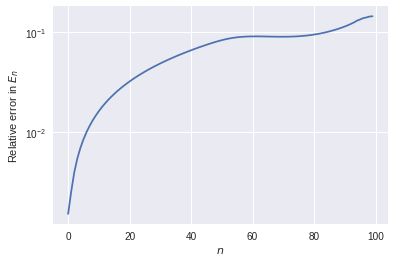

In [2]:
%pylab inline --no-import-all
hbar = m = omega = 1

def get_x_H(N=128, L=20.0):
  dx = L/N
  n = np.arange(N)
  x = n*dx - L/2
  D2 = (-2*np.diag(np.ones(N))      # Finite difference matrix: Dirichlet
        + np.diag(np.ones(N-1), 1) 
        + np.diag(np.ones(N-1), -1)
       )/dx**2
  K = -hbar**2*D2/2/m
  V = m*omega**2*np.diag(x**2)/2
  H = K + V
  assert np.allclose(H, H.conj().T)
  return x, H

x, H = get_x_H(N=128)
n = np.arange(len(x))
En_exact = hbar*omega*n + 0.5
En = np.linalg.eigvalsh(H)
plt.semilogy(n[:100], abs((En/En_exact-1)[:100]))
plt.xlabel('$n$')
plt.ylabel('Relative error in $E_n$')

Let's check the scaling of the error in the ground state energy:

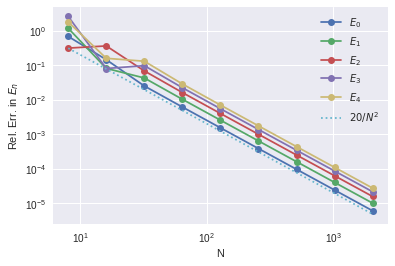

In [3]:
Ns = 2**np.arange(3, 12)
errs = []
for N in Ns:
  x, H = get_x_H(N=N)
  errs.append(np.linalg.eigvalsh(H)[:5]/En_exact[:5] - 1)
 
for n, _ in enumerate(errs[0]):
  plt.loglog(Ns, np.abs(errs)[:, n], '-o', label=f"$E_{n}$")
plt.loglog(Ns, 20./Ns**2, ':', label="$20/N^2$")
plt.xlabel('N')
plt.ylabel('Rel. Err. in $E_n$')
plt.legend()

From this we see that indeed, the errors scale as $\d{x}^2 \propto N^{-2}$ and that to get 5 digits of precision we need $N>2000$ although for 1% accuracy in the energies, we can have $N\approx 100$.

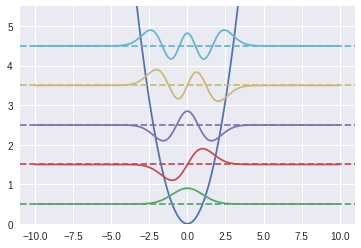

In [5]:
#@title Eigenstates of the Harmonic Oscillator { run: "auto", vertical-output: true }
n_max = 5 #@param {type:"slider", min:5, max:30, step:1}

x, H = get_x_H(N=1000)
V = m*omega**2/2*x**2

En, psi_n = np.linalg.eigh(H)
plt.plot(x, V)
for n in range(n_max):
  E = En[n]
  psi = psi_n[:, n]
  l, = plt.plot(x, E + 0.4*hbar*omega*psi/abs(psi).max())
  plt.axhline(E, ls='--', c=l.get_c())

plt.ylim(0, En[n_max]);


## Basis States (Incomplete)

As we mentioned earlier, the finite difference approach is equivalent to using a set of basis states, but exactly what these basis states are depends on the discretization approach.


# Fourier Methods (Spectral Methods)

As demonstrated above, the error incurred by using a finite-difference approximation scales as the lattice spacing to some power: $\d{x}^2$ in the simple form we used above.  To achive high precision results thus requires a very small lattice spacing, and therefore a large number of points.

Spectral methods use a basis of plane-waves or sines and cosines instead.  This requires representing the problem in a periodic box, but can significantly improve the accuracy, which becomes exponential if the potential is an analytic function (infinitely differentiable for example).

For a periodic box of length $L$ we have the following completeness relation (for continuous functions):

$$
  \op{1} = \int_{0}^{L} \d{x} \ket{x}\bra{x}.
$$

use the following basis set $\ket{k_n}$ for integer $n$:

$$
  \braket{x|k_n} = \frac{1}{\sqrt{L}} e^{\I k_n x}, \qquad
  k_n = \frac{2\pi n}{L}.
$$

These plane-wave states are orthonormal:

$$
  \braket{k_m|k_n} = \int_{0}^{L}\d{x} \braket{k_m|x}\braket{x|k_n}
  = \frac{1}{L} \int_{0}^{L}\d{x} e^{\I x(k_n - k_m)}
  = \frac{1}{L}\frac{e^{\overbrace{\I L(k_n - k_m)}^{2\pi\I(n-m)}} - 1}{\I(k_n-k_m)}
  = \delta_{mn}.
$$

There are still an infinite number of these plane-wave states, so to render the basis finite for numerical use, we must consider only states with $\abs{k_n} < k_c$ and so we restrict $n$:

$$
  k_n = \frac{2\pi n}{L}\Biggr|_{n=-\Floor{\frac{N}{2}}}^{\Floor{\frac{N-1}{2}}}.
$$

*The use of the floor function here, $\floor{N/2}$ etc., ensures that for both even and odd $N$, the momenta correspond with those momenta used numerically by the FFT algorithm.*

To project onto this restricted finite basis we may use:

$$
  \op{P}_{N,L} = \sum_{n=-\Floor{\frac{N}{2}}}^{\Floor{\frac{N-1}{2}}} \ket{k_n}\bra{k_n}
  \equiv \sum_{n}\ket{k_n}\bra{k_n}.
$$

*To simplify notations, we shall drop the explicit indices in the sum when they are clear from context.*

With this restriction, we may restrict our attention to a finite set of $N$ points (abscissa) in position space on account of the [Nyquist-Shannon Sampling Theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem):

$$
  x_n = n\Delta |_{n=0}^{N-1}.
$$

To emphasize this, we may write our position-space eigenstates as projected delta-functions:

$$
  \braket{x|\op{P}_{N,L}|x_n} = \sum_{m}\braket{x|k_m}\braket{k_m|x_n}
  = \frac{1}{L}\sum_{m}e^{\overbrace{\I k_m(x-x_n)}^{2\pi m\I(x-x_n)/L}} = f(x-x_n)\\
  f(x)= \frac{1}{L}\sum_{m=-\Floor{\frac{N}{2}}}^{\Floor{\frac{N-1}{2}}}
  \overbrace{\left(e^{2\pi\I x/L}\right)^m}^{Q^m}
  = \frac{Q^{N} - 1}{L(Q-1)}Q^{-\Floor{\frac{N}{2}}}
  = \frac{1}{L}\frac{e^{2\pi \I N x/L} - 1}{e^{2\pi\I x/L}-1}e^{-2\pi \Floor{\frac{N}{2}}\I x/L}\\
  = \frac{1}{L}\frac{e^{2\pi \I N x/L} - 1}{e^{2\pi\I x/L}-1}e^{\I k_\min x}, 
  \qquad
  k_{\min} = -\frac{2\pi}{L}\Floor{\frac{N}{2}}
$$

*Note that the last factor simply shifts the momentum down so that it is symmetric between $-k_c$ and $k_c$ rather than going from $0$ to $k_c$ which would be the case if $n \in \{0, 1, \cdots N-1\}$.*

Projection does not generally preserve norms:

$$
  \int_0^L\d{x} \abs{f(x)}^2 = \frac{N}{L}
$$

so these functons need to be renormalized.  Within the basis, the correct position-space basis functions are thus:

$$
  \psi_n(x) = \braket{x|x_n} = \psi_0(x-x_n)\\ 
  \psi_0(x) = \frac{1}{\sqrt{NL}}\frac{e^{2\pi \I N x/L} - 1}{e^{2\pi\I x/L}-1}e^{\I k_\min x}
                   = \frac{1}{\sqrt{NL}}\frac{\sin\frac{\pi N x}{L}}{\sin\frac{\pi x}{L}}e^{\I \delta_kx}\\
  \delta_k = \frac{2\pi(N\;\mathrm{mod}\;2 - 1)}{L}
$$

*The remaining phase factor is physically inconsequential and may be dropped (it vanishes for odd $N$ for example), however, must be included if you want direct comparison with numerical implementations of the FFT*.

These basis functions have some very interesting properties.  They are projected delta-functions, so one would expect them to be sharply peaked at $x=0$ and indeed they are.  They are all identical in form except translated by $x_n$.  The are periodic versions of the [Sinc function](https://en.wikipedia.org/wiki/Sinc_function) $\sinc(x) = \sin(x)/x$.  They also happen to vanish on all lattice points $x_m$ except the matching point $\psi_n(x_m) \propto \delta_{mn}$:

$$
  \psi_n(x + L) = \psi_n(x), \qquad
  \psi_0(x) \approx \frac{1}{\sqrt{\Delta}}\sinc\frac{\pi x}{\Delta}, \qquad
  \psi_m(x_n) = \sqrt{\frac{N}{L}}\delta_{mn} = \frac{\delta_{mn}}{\sqrt{\Delta}}\\
$$

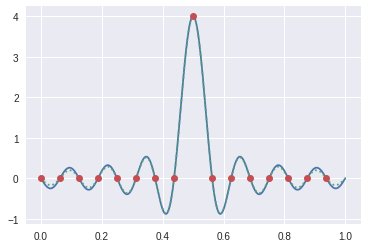

In [36]:
N = 16
L = 1.0
dx = L/N
n = np.arange(N)
m = n - int(np.floor(N/2))
x = n*dx
k = 2*np.pi * m/L

X = np.linspace(0, L, 1000)
def psi_0(x):
  return ((np.exp(2*np.pi*N*1j*x/L) - 1)
          /(np.exp(2*np.pi*1j*x/L)-1)
          /np.sqrt(N*L))
def psi_0r(x):
  return (np.sin(np.pi*x/dx)
          /np.sin(np.pi*x/L)
          /np.sqrt(N*L))
def sinc_0(x):
  return np.sin(np.pi*x/dx)/(np.pi*x/dx)/np.sqrt(dx)

plt.plot(X, psi_0r(X-x[N//2]))
plt.plot(X, sinc_0(X-x[N//2]), ':')
plt.plot(x, psi_0r(x-x[N//2]+1e-32), 'o')


# Time Dependent Schrödinger Equation


Here we present a general method of solution for the time-dependent Schrödinger equation.

In [70]:
%pylab inline --no-import-all
from matplotlib import animation, rc
from IPython.display import HTML, clear_output

class MovieBase(object):
  def __init__(self):
    self.fig = plt.figure(figsize=(10,5))
    self.ts = np.linspace(0, 1, 10)
    self.x = np.linspace(0, 1, 200)
    self.line1, = plt.plot(self.x, np.sin(2*np.pi*self.x))
        
  def update_frame(self, frame):
    """Update or draw the specified frame."""
    t = self.ts[frame]
    x = self.x
    self.line1.set_data(x, np.sin(2*np.pi*x*(1+t)))
    return [self.line1]
    
  def initial_frame(self):
    """Draw the initial frame and return the artists."""
    return self.update_frame(0)
  
  def show_animation(self):
    anim = animation.FuncAnimation(
      self.fig, self.update_frame, init_func=self.initial_frame, 
      frames=len(self.ts), interval=50, repeat=False, blit=True)
    plt.close('all')
    rc('animation', html='jshtml')
    return anim
  
  @property
  def anim(self):
    return self.show_animation()

#MovieBase().anim

Populating the interactive namespace from numpy and matplotlib


No handles with labels found to put in legend.


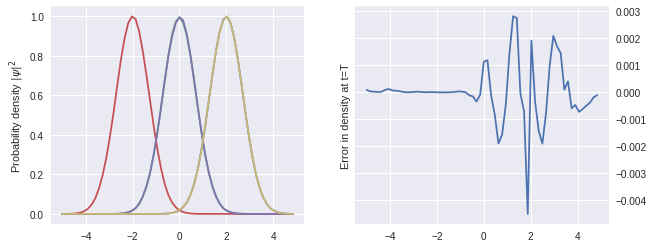

In [113]:
N = 64
L = 10.0
dx = L/N
x = np.arange(N)*dx - L/2
k = 2*np.pi * np.fft.fftfreq(N, dx)

hbar = m = w = 1

Vx = m*(w*x)**2/2
Kk = (hbar*k)**2/2/m

def apply_exp_K(psi, dt, Kk=Kk):
  """Return exp(-1j*K*dt/hbar) applied to psi."""
  return np.fft.ifft(np.exp(Kk*dt/1j/hbar)*np.fft.fft(psi))

def apply_exp_V(psi, dt, Vx=Vx):
  """Return exp(-1j*V*dt/hbar) applied to psi."""
  return np.exp(Vx*dt/1j/hbar)*psi

def evolve(psi, steps, dt, Kk=Kk, Vx=Vx):
  """Return psi(t + steps*dt)."""
  psi = apply_exp_V(psi, dt/2.0, Vx=Vx)
  for n in range(steps):
    psi = apply_exp_V(apply_exp_K(psi, dt, Kk=Kk), dt, Vx=Vx)
  return apply_exp_V(psi, -dt/2.0, Vx=Vx)

# Insert a Gaussian and watch it oscillate
psi0 = np.exp(-(x-2)**2/2)

T = np.pi/w/2   # Quarter trapping period
dt = 0.5 * hbar/Kk.max()
steps = int(np.ceil(T/2/dt))
dt = T/steps
psi1 = evolve(psi0, steps, dt=dt)
psi2 = evolve(psi1, steps, dt=dt)
psi3 = evolve(psi2, steps, dt=dt)
psi4 = evolve(psi3, steps, dt=dt)

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(x, abs(psi0)**2, label="t=0")
plt.plot(x, abs(psi1)**2, label="t=T/4")
plt.plot(x, abs(psi2)**2, label="t=T/2")
plt.plot(x, abs(psi3)**2, label="t=3T/4")
plt.plot(x, abs(psi4)**2, label="t=T")
plt.ylabel("x"); plt.ylabel(r"Probability density $|\psi|^2$")

plt.subplot(122).yaxis.tick_right()
plt.plot(x, abs(psi4)**2 - abs(psi0)**2)
plt.ylabel("x"); plt.ylabel("Error in density at t=T")
plt.legend()


In [115]:
class Movie(MovieBase):
  def __init__(self, Nx=64, Nt=100, steps=200, Lx=10.0, x0=2.0, dt_t_scale=0.5):
    self.fig = plt.figure(figsize=(10,5))
    N = 64
    L = 10.0
    dx = L/N
    self.steps = steps
    self.x = np.arange(N)*dx - L/2
    self.k = 2*np.pi * np.fft.fftfreq(N, dx)

    hbar = m = w = 1

    self.Vx = m*(w*self.x)**2/2
    self.Kk = (hbar*self.k)**2/2/m
    
    E_max = self.Kk.max()
    t_scale = hbar/E_max
    self.dt = dt_t_scale*t_scale
    self.psi = np.exp(-(x-x0)**2/2)
    self.ts = np.arange(Nt) * self.dt
    self.line, = plt.plot(self.x, abs(self.psi)**2)
    self.title = plt.title("t=0")
        
  def update_frame(self, frame):
    """Update or draw the specified frame."""
    if frame > 0:
      self.psi = evolve(self.psi, self.steps, dt=self.dt, Kk=self.Kk, Vx=self.Vx)
    self.line.set_data(self.x, abs(self.psi)**2)
    self.title.text = "t={:.4f}".format(self.ts[frame])
    return [self.line, self.title]

Movie().anim    

In class we worked out the Fourier transform and its inverse for a function as follows:

\begin{gather}
  \tilde{f}_m = \braket{k_m|f} = \braket{k_m|\op{1}|f}
  = \Delta\sum_{n}\braket{k_m|x_n}\braket{x_n|f}
  = \overbrace{
    \Delta\sum_{m}e^{-\I k_m x_n}f_n
  }^{\int \d{x}\; e^{-\I k x}f(x)}
  ,\tag{Fourier Transform}\\
  f_n \equiv f(x_n) = \braket{x_n|f} = \braket{x_n|\op{1}|f}
  = \frac{1}{L}\sum_{m}\braket{x_n|k_m}\braket{k_m|f}
  = \overbrace{
    \frac{1}{L}\sum_{m}e^{\I k_m x_n}\tilde{f}_m
  }^{\int\frac{\d{k}}{(2\pi)}\; e^{\I k x}\tilde{f}_k}.\tag{inverse Transform}
\end{gather}

These normalizations are useful in order to connect with the continuum limit (shown on the far right):

\begin{align}
  \text{Discrete}
  &&&\equiv&&
  \text{Continuum}\\
  x_n = \Delta n\bigr|_{n=0}^{N-1}
  &&&\equiv&&
  x\in[0, L)\\
  k_m = \frac{2\pi m}{L}\Biggr|_{n=-\Floor{\frac{N}{2}}}^{\Floor{\frac{N-1}{2}}}
  &&&\equiv&&
  k\in[-k_\max, k_\max), \qquad k_\max = \frac{N\pi}{L},\\
  \sum_{n}=\sum_{n=0}^{N-1}
  &&&&&
  \int\d{x} \equiv \int_{0}^{L}\d{x},\qquad
  \int\frac{\d{k}}{2\pi} \equiv \int_{-k_\max}^{k_\max}\frac{\d{k}}{2\pi},\\  
  \braket{x_m|x_n} = \frac{\delta_{mn}}{\Delta}
  &&&\equiv&&
  \delta(x_m-x_n),\\
  \braket{k_m|k_n} = L\delta_{mn}
  &&&\equiv&&
  (2\pi)\delta(k_m-k_n),\\
  \op{1} = \Delta\sum_{n} \ket{x_n}\bra{x_n}
  &&&\equiv&&
  \int\d{x}\; \ket{x}\bra{x},\\
  \op{1} = \frac{1}{L}\sum_{n} \ket{k_n}\bra{k_n}
  &&&\equiv&&
  \int \frac{\d{k}}{2\pi}\ket{k}\bra{k}.
\end{align}

### Numerical Normalization

For numerical work, it is convenient to change the conventions slightly so that $\braket{x_m|x_n} = \braket{k_m|k_n} = N\delta_{mn}$.  Here are the corresponding conventions, which basically amount to effecting the following substitutions into the previous equations:

$$
  \ket{x_n} \rightarrow \frac{\ket{x_n}}{\sqrt{\Delta}}, \qquad
  \ket{k_m} \rightarrow \sqrt{\Delta}\ket{k_m}, \\
  \op{1} = \sum_{n} \ket{x_n}\bra{x_n} = \frac{1}{N}\sum_{n} \ket{k_n}\bra{k_n}, \qquad
  \braket{x_n|k_m} = e^{\I k_mx_n}, \qquad
$$


### Alternative Normalization

An alternative normalization is to make $\braket{x_m|x_n} = \braket{k_m|k_n} = \delta_{mn}$.  This makes the Fourier transform matrix $U_{mn} = \braket{k_m|x_n}$ manifestly unitary, but does not correspond with common implementations of the Fourier transform via the FFT algorithm:

$$
  \ket{x_n} \rightarrow \frac{\ket{x_n}}{\sqrt{\Delta}}, \qquad
  \ket{k_m} \rightarrow \sqrt{L}\ket{k_m}, \\
  \op{1} = \sum_{n} \ket{x_n}\bra{x_n} = \sum_{n} \ket{k_n}\bra{k_n}, \\
  \braket{x_n|k_m} = \frac{1}{\sqrt{N}}e^{\I k_mx_n}, \qquad
$$


### Code

In code, we use the Numerical Normalization and have:

$$
  \texttt{dx}=\Delta, \qquad
  \texttt{dk}=\frac{2\pi}{L}, \qquad
$$



In [1]:
# This cell loads the plotting and numeric libraries
# from matplotlib import pyplot as plt
# import numpy as np
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [0]:
N = 64             # Number of lattice points
L = 20.0           # Box size
dx = L/N           # Lattice spacing
dk = 2*np.pi/L     # Momentum spacing
ns = np.arange(N)  # Array of [0, 1, ..., N-1]
xs = ns*dx         # Lattice points

# The momentum ordering may seem a little peculiar but is chosen
# for performance.  The ordering corresponds to setting
# n = [0, 1, ..., N-1] but aliasing so that the higher momenta wrap
# back into negative momentum states.  We show explicitly the formulation
# below but rely on the FFT code to return the correct order in our work.
ks = 2*np.pi * np.fft.fftfreq(N, dx)  # Momenta in the order computed by the FFT
ks_ = dk * ((ns + N//2) % N - N//2)   # Explicit ordering for reference...
assert np.allclose(ks, ks_)           # Check that we got it right!

Here we compute explicitly the matrix $\op{U}$ which implements the FFT:

$$
  U_{mn} = e^{-\I k_m x_n} = e^{-2\pi\I m n / N}.
$$

In our Numerical Normalization, this is not unitary and the inverse is:

$$
  \mat{U}^{-1} = \frac{1}{N}\mat{U}^{\dagger}, \qquad
  U^{-1}_{mn} = \frac{1}{N}e^{\I k_m x_n} = \frac{1}{N}e^{-2\pi\I m n / N}.
$$

In [0]:
U = np.exp(1j*ks[:,None]*xs[None,:])
Uinv = U.conj().T/N
assert np.allclose(Uinv.dot(U), np.eye(N))

Here we examine a normalized Gaussian and some related integrals:

$$
  G(x) = \frac{1}{\sqrt{2\pi} \sigma}e^{-(x-L/2)^2/2\sigma^2}, \qquad
  \int \d{x}\;G(x) = 1, \\
  \int \d{x}\; e^{-\alpha x^2} = \sqrt{\frac{\pi}{\alpha}}, \qquad
  \int \d{x}\; e^{-\alpha (x-\bar{x})^2 + \beta x}
  =
  \int \d{x}\; e^{-\alpha (x-\bar{x}-x_0)^2 + 2\alpha\bar{x}x_0 + \alpha x_0^2}
  =
  e^{\beta^2/4\alpha+ \beta\bar{x}}\sqrt{\frac{\pi}{\alpha}}, \qquad
  x_0 = \frac{\beta}{2\alpha}, \\
  \int \d{x}\; G(x)e^{\beta x} = e^{\sigma^2\beta^2/2}
$$

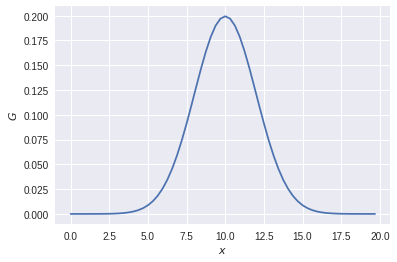

In [4]:
sigma = 2.0
G = np.exp(-(xs-L/2)**2/2/sigma**2)/np.sqrt(2*np.pi)/sigma
plt.plot(xs, G)
plt.xlabel('$x$'); plt.ylabel('$G$')
assert np.allclose(np.sum(G)*dx, 1)   # Check that it is normalized.

Now we compute the Fourier transform of the Gaussian $G(x)$:

$$
  \tilde{G}_k = \braket{k|G} = \int \d{x}\;\braket{k|x}\braket{x|G}
  = \int \d{x}\; e^{-\I k x}G(x)
  = e^{-\sigma^2 k^2/2 - \I k L/2}
$$

When using the Numerical Normalization, the factor of $\d{x}$ in the integral is not included, so we must remove this when comparing:

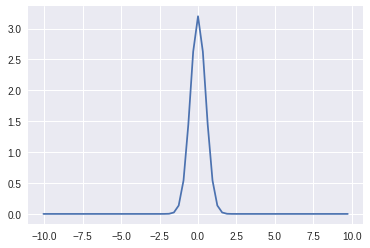

In [85]:
# This makes the momenta ks ordered
from numpy.fft import fftshift
ks_ = fftshift(ks)
Gk = np.fft.fft(G)
assert np.allclose(U.dot(G), Gk)
Gk_ = fftshift(Gk)
Gk_exact_ = np.exp(-sigma**2*ks_**2/2-1j*L*ks_/2) / dx
assert np.allclose(Gk_, Gk_exact_, rtol=1e-5, atol=1e-5)
plt.plot(ks_, abs(Gk_))

Finally, we check the example from class for half of a square wave in the box:

$$
  \tilde{f}_n = \braket{k_n|f} = \int_0^{L} \d{x}\; \braket{k_n|x}\braket{x|f}
  = \int_0^{L/2} \d{x}\; e^{-\I k_n x}
  = \frac{\I}{k_n}\overbrace{
    \left(e^{-\I k_nL/2}-1\right)
  }^{e^{-\I\pi n}-1}
  = \begin{cases}
   \frac{L}{2}& k_n = 0,\\
    0 & \text{even } n,\\
    \frac{2}{\I k_n} & \text{odd } ,n
  \end{cases}\\
  f(x) = \frac{L}{2} + \sum_{\text{odd }n}\frac{2e^{\I k_n x}}{\I k_n}.
$$

Again, to compare with the Numerical Normalization, we must remove the factor of $\d{x}$ and include the factor of $N$ when performing the inverse FFT:

$$
  f_n = \frac{\frac{L}{2} +\sum_{\text{odd }n}\frac{2e^{\I k_n x}}{\I k_n}}{N\d{x}}
   = \frac{1}{2} +\sum_{\text{odd }n}\frac{2e^{\I k_n x}}{\I k_n L}
$$

In [173]:
with np.errstate(invalid='ignore'):
    fk_n = np.where(ns%2==0,
                    0,
                    np.divide(2, 1j*ks))
fk_n[0] = L/2
fk_n /= dx

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


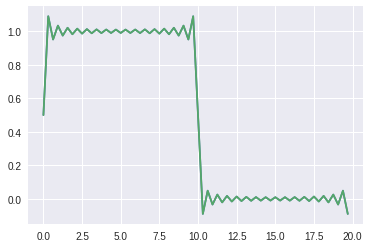

In [174]:
plt.plot(xs, np.fft.ifft(fk_n))
plt.plot(xs, np.exp(1j*ks[None, :]*xs[:,None]).dot(fk_n)/N)